# Comprehensive VQE Demo: Theory and Practice
# Authors: Bentke, Hufler, Balles
# Date: December 1, 2024

This notebook provides a complete theoretical and practical demonstration of
Variational Quantum Eigensolvers (VQE) with advanced optimization techniques.

Topics covered:
1. VQE Theory and Gradient Computation
2. Quantum Natural Gradient Descent
3. Fisher Information Matrix
4. Single Qubit Systems
5. Ising Models
6. Molecular Chemistry (H2)
7. Optimizer Comparisons

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

import sys
sys.path.append("src")

#Import the VQE framework
from base_optimizer import *

#Setup directory
RESULTS_DIR = Path("results/12-1-Fynn")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

## SECTION 1: VQE THEORY

### Variational Quantum Eigensolver (VQE)

#### Basic Principle
VQE is a hybrid quantum-classical algorithm for finding ground states of quantum systems.

**Goal:** Finding the lowest eigenenergy of a Hamiltonian by minimizing the energy expectation value  
    E(θ) = ⟨ψ(θ)|H|ψ(θ)⟩

Where:
- H is the Hamiltonian (observable)
- |ψ(θ)⟩ is a parameterized quantum state, prepared by a unitary operation (ansatz)
- θ are classical parameters

A quantum computer evaluates E(θ), while a classical computer updates θ to minimize E(θ).
** Challenges:** 
- Too many parameters: Optimization becomes slow
- Too few parameters: Ansatz may not represent the true ground state,leadint to the VQE finding excited energies instead of the ground state energy.

### Optimization methods 
#### Gradient Descent Update Rule
    θ_{k+1} = θ_k - η ∇E(θ_k)

Where η is the learning rate (step size).


#### Quantum Natural Gradient Descent

Standard gradient descent doesn't account for the geometry of the parameter space. The **natural gradient** uses the Fisher Information Matrix:

    θ_{k+1} = θ_k - η F^{-1}(θ_k) ∇E(θ_k)

Where F is the Fisher Information Matrix (quantum geometric tensor).

#### Benefits:
- Invariant under reparametrization
- Can lead to faster convergence
- Avoids plateaus in optimization landscape

#### Challenges:
- Computing F requires O(n²) circuit evaluations
- Matrix inversion can be numerically unstable
- Requires regularization


In [6]:
print("\n" + "=" * 80)
print("SECTION 2: SINGLE QUBIT SYSTEM")
print("=" * 80)

# Running VQE with different optimizers
optimizers_single = {
    'Finite Diff + Const': VQE_OneQubit_FiniteDiff_Const(
        max_iter=100,
        learning_rate=0.05,
        gradient_eps=1e-6,
        store_history=True
    ),
    'PSR + Adam': VQE_OneQubit_PSR_Adam(
        max_iter=100,
        learning_rate=0.05,
        store_history=True,
        reps=0
    ),
    'QNG': VQE_OneQubit_QNG(
        max_iter=100,
        learning_rate=0.05,
        decay=0.01,
        fisher_reg=1e-6,
        store_history=True,
        reps=0
    )
}

results_single = {}
initial_theta = np.array([np.pi/2])

for name, optimizer in optimizers_single.items():
    print(f"\nOptimizer: {name}")
    theta_opt, E_opt = optimizer.run(initial_params=initial_theta)
    results_single[name] = {
        'theta': theta_opt,
        'energy': E_opt,
        'history': optimizer.history_energy,
        'error': abs(E_opt + np.sqrt(2))
    }
    print(f"  Final Energy: {E_opt:.6f}")
    print(f"  Error: {abs(E_opt + np.sqrt(2)):.6e}")



### Gradient Computation Methods

1. **Finite Differences** (Numerical)  
   ∂E/∂θ_i ≈ [E(θ + ε·e_i) - E(θ)] / ε  
   - Pros: Simple, works for any function  
   - Cons: Requires O(n) circuit evaluations, approximation error  

2. **Parameter Shift Rule** (Exact for quantum circuits)  
   ∂E/∂θ_i = [E(θ + π/2·e_i) - E(θ - π/2·e_i)] / 2  
   - Pros: Exact (no approximation), no need for small ε  
   - Cons: Requires 2n circuit evaluations  

3. **SPSA** (Simultaneous Perturbation)  
   ∇E ≈ [E(θ + ε·Δ) - E(θ - ε·Δ)] / (2ε) · Δ where Δ is a random direction  
   - Pros: Only 2 circuit evaluations regardless of dimension  
   - Cons: Noisy gradient estimate, requires careful tuning  

SECTION 2: SINGLE QUBIT SYSTEM

Optimizer: Finite Diff + Const
Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Iteration 20/100 (20.0%)
Iteration 30/100 (30.0%)
Iteration 40/100 (40.0%)
Iteration 50/100 (50.0%)
Iteration 60/100 (60.0%)
Iteration 70/100 (70.0%)
Converged at iteration 76
  Final Energy: -1.41


✓ Saved: results/12-1-Fynn/single_qubit_comparison.png


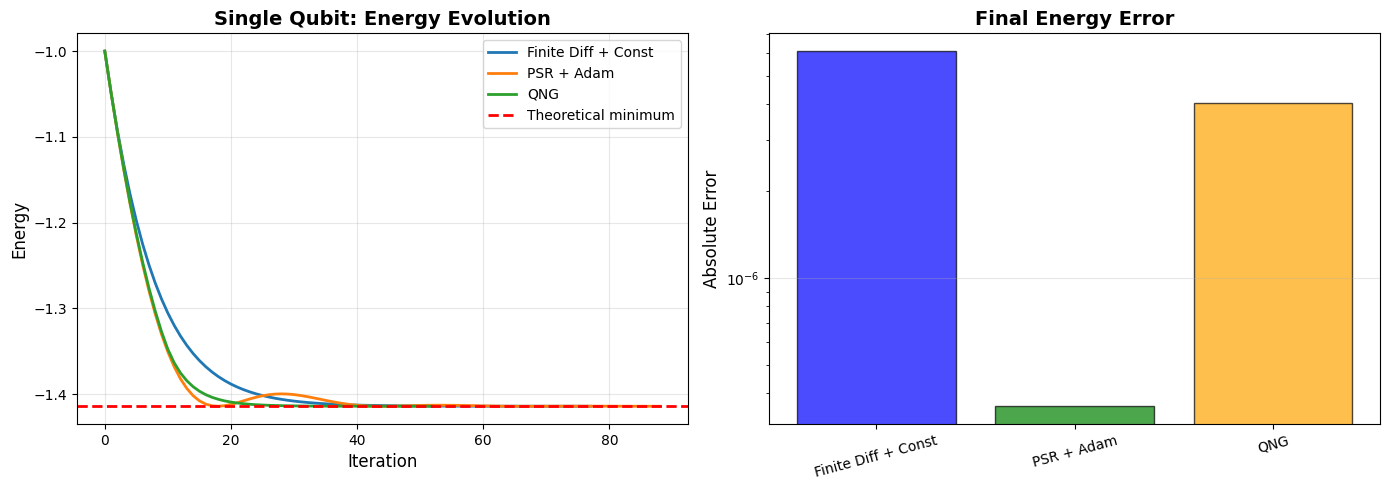

In [ ]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Energy evolution
ax1 = axes[0]
for name, result in results_single.items():
    ax1.plot(result['history'], label=name, linewidth=2)
ax1.axhline(-np.sqrt(2), color='red', linestyle='--', linewidth=2, 
            label='Theoretical minimum')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Energy', fontsize=12)
ax1.set_title('Single Qubit: Energy Evolution', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Final errors
ax2 = axes[1]
names = list(results_single.keys())
errors = [results_single[name]['error'] for name in names]
colors = ['blue', 'green', 'orange']
ax2.bar(names, errors, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Absolute Error', fontsize=12)
ax2.set_title('Final Energy Error', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'single_qubit_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n Saved: {RESULTS_DIR / 'single_qubit_comparison.png'}")
plt.show()

## SECTION 4: ISING MODEL

### Ising Model Hamiltonian
    H = -Σ_i h_i Z_i - Σ_{i<j} J_{ij} Z_i Z_j

Where:
- h_i: external magnetic field on qubit i
- J_{ij}: coupling strength between qubits i and j
- Z_i: Pauli-Z operator on qubit i

This model describes magnetic interactions and is used in:
- Condensed matter physics
- Optimization problems (QAOA)
- Machine learning (Boltzmann machines)


In [ ]:
# Define 3-qubit Ising model
J = np.array([
    [0.0,  1.0,  0.5],
    [1.0,  0.0,  0.8],
    [0.5,  0.8,  0.0],
], dtype=float)

h = np.array([0.3, -0.2, 0.1], dtype=float)

print("Coupling matrix J:")
print(J)
print("\nExternal field h:")
print(h)

print("\n--- Run Ising Model VQE ---\n")

# Compare different optimizers
optimizers_ising = {
    'PSR + Adam': VQE_Ising_PSR_Adam(
        max_iter=200,
        learning_rate=0.05,
        store_history=True,
        reps=2,
        J=J,
        h=h
    ),
    'SPSA + Adam': VQE_Ising_SPSA_Adam(
        max_iter=200,
        learning_rate=0.05,
        gradient_eps=0.1,
        store_history=True,
        reps=2,
        J=J,
        h=h
    ),
    'QNG': VQE_Ising_QNG(
        max_iter=200,
        learning_rate=0.1,
        decay=0.02,
        fisher_reg=1e-5,
        store_history=True,
        reps=2,
        J=J,
        h=h
    )
}

results_ising = {}

for name, optimizer in optimizers_ising.items():
    print(f"\nOptimizer: {name}")
    n_params = (optimizer.reps + 1) * 3
    theta_init = np.random.uniform(0, 2*np.pi, n_params)
    
    theta_opt, E_opt = optimizer.run(initial_params=theta_init)
    results_ising[name] = {
        'theta': theta_opt,
        'energy': E_opt,
        'history': optimizer.history_energy
    }
    print(f"  Final Energy: {E_opt:.6f}")


Coupling matrix J:
[[0.  1.  0.5]
 [1.  0.  0.8]
 [0.5 0.8 0. ]]

External field h:
[ 0.3 -0.2  0.1]

--- Running Ising Model VQE ---


Optimizer: PSR + Adam
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Iteration 40/200 (20.0%)
Iteration 50/200 (25.0%)
Iteration 60/200 (30.0%)
Iteration 70/200 (35.0%)
Iteration 80/200 (40.0%)
Iteration 90/200 (45.0%)
Iteration 100/200 (50.0%)
Converged at iteration 101
  Final Energy: -2.499955

Optimizer: SPSA + Adam
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Iteration 40/200 (20.0%)
Iteration 50/200 (25.0%)
Iteration 60/200 (30.0%)
Iteration 70/200 (35.0%)
Iteration 80/200 (40.0%)
Iteration 90/200 (45.0%)
Iteration 100/200 (50.0%)
Iteration 110/200 (55.0%)
Iteration 120/200 (60.0%)
Iteration 130/200 (65.0%)
Iteration 140/200 (70.0%)
Iteration 150/200 (75.0%)
Iteration 160/200 (80.0%)
Iteration 170/200 (85.0%)
Iteration 180/200 (90.0%)
Iteration 1


✓ Saved: results/12-1-Fynn/ising_model_comparison.png


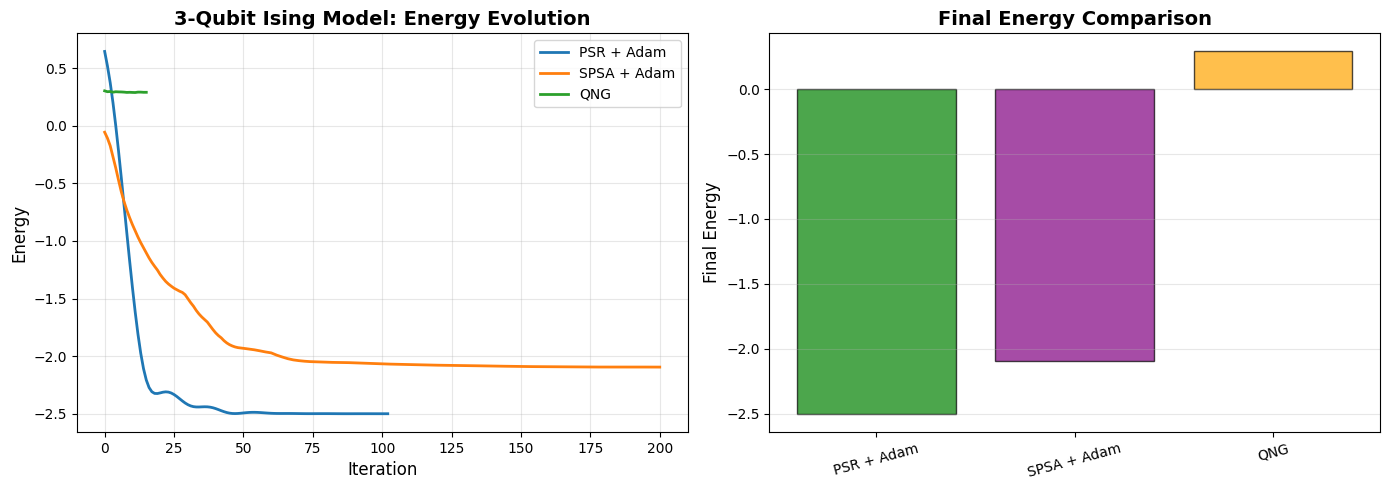

In [ ]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Energy evolution
ax1 = axes[0]
for name, result in results_ising.items():
    ax1.plot(result['history'], label=name, linewidth=2)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Energy', fontsize=12)
ax1.set_title('3-Qubit Ising Model: Energy Evolution', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Final energies comparison
ax2 = axes[1]
names = list(results_ising.keys())
final_energies = [results_ising[name]['energy'] for name in names]
colors = ['green', 'purple', 'orange']
ax2.bar(names, final_energies, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Final Energy', fontsize=12)
ax2.set_title('Final Energy Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'ising_model_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n Saved: {RESULTS_DIR / 'ising_model_comparison.png'}")
plt.show()

## SECTION 5: LEARNING RATE SENSITIVITY ANALYSIS

Learning rate is crucial for optimization performance.  
Too small: slow convergence  
Too large: instability, divergence

We test multiple learning rates to find the optimal range.


In [10]:
learning_rates = np.logspace(-2.5, -0.5, 15)  # 0.003 to 0.3
results_lr = []

print("\n--- Testing learning rates ---")
for i, lr in enumerate(learning_rates):
    print(f"Progress: {i+1}/{len(learning_rates)} (lr={lr:.4f})")
    
    vqe = VQE_OneQubit_PSR_Adam(
        max_iter=100,
        learning_rate=lr,
        store_history=True,
        reps=0
    )
    
    theta_opt, E_opt = vqe.run(initial_params=np.array([np.pi/2]))
    
    results_lr.append({
        'lr': lr,
        'energy': E_opt,
        'error': abs(E_opt + np.sqrt(2)),
        'history': vqe.history_energy
    })



--- Testing learning rates ---
Progress: 1/15 (lr=0.0032)
Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Iteration 20/100 (20.0%)
Iteration 30/100 (30.0%)
Iteration 40/100 (40.0%)
Iteration 50/100 (50.0%)
Iteration 60/100 (60.0%)
Iteration 70/100 (70.0%)
Iteration 80/100 (80.0%)
Iteration 90/100 (90.0%)
Progress: 2/15 (lr=0.0044)
Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Iteration 20/100 (20.0%)
Iteration 30/100 (30.0%)
Iteration 40/100 (40.0%)
Iteration 50/100 (50.0%)
Iteration 60/100 (60.0%)
Iteration 70/100 (70.0%)
Iteration 80/100 (80.0%)
Iteration 90/100 (90.0%)
Progress: 3/15 (lr=0.0061)
Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Iteration 20/100 (20.0%)
Iteration 30/100 (30.0%)
Iteration 40/100 (40.0%)
Iteration 50/100 (50.0%)
Iteration 60/100 (60.0%)
Iteration 70/100 (70.0%)
Iteration 80/100 (80.0%)
Iteration 90/100 (90.0%)
Progress: 4/15 (lr=0.0085)
Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Iteration 20/100 (20.0%)
Iteration 30/100 (30.0%)
Iteration 40/100 (


✓ Saved: results/12-1-Fynn/learning_rate_study.png


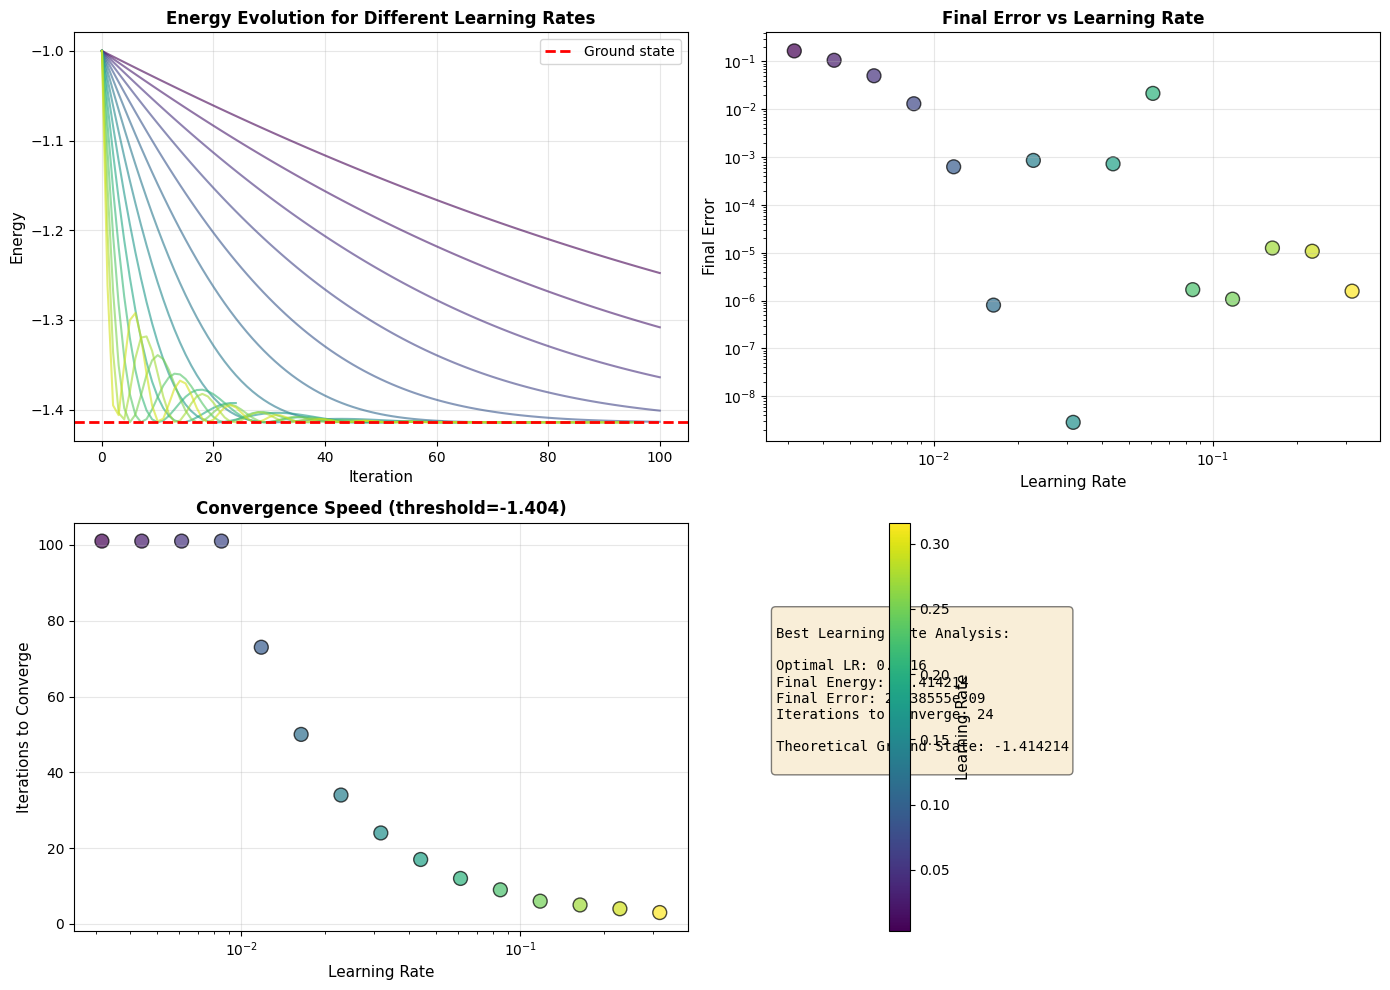

In [ ]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# All trajectories
ax1 = axes[0, 0]
cmap = plt.cm.viridis
for i, result in enumerate(results_lr):
    color = cmap(i / len(results_lr))
    ax1.plot(result['history'], color=color, alpha=0.6, linewidth=1.5)
ax1.axhline(-np.sqrt(2), color='red', linestyle='--', linewidth=2, label='Ground state')
ax1.set_xlabel('Iteration', fontsize=11)
ax1.set_ylabel('Energy', fontsize=11)
ax1.set_title('Energy Evolution for Different Learning Rates', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Final error vs learning rate
ax2 = axes[0, 1]
lrs = [r['lr'] for r in results_lr]
errors = [r['error'] for r in results_lr]
ax2.scatter(lrs, errors, c=range(len(lrs)), cmap='viridis', s=100, 
            alpha=0.7, edgecolors='black')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Learning Rate', fontsize=11)
ax2.set_ylabel('Final Error', fontsize=11)
ax2.set_title('Final Error vs Learning Rate', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Convergence speed
ax3 = axes[1, 0]
threshold = -np.sqrt(2) + 0.01
iterations_to_converge = []
for result in results_lr:
    converged = False
    for it, E in enumerate(result['history']):
        if E <= threshold:
            iterations_to_converge.append(it)
            converged = True
            break
    if not converged:
        iterations_to_converge.append(len(result['history']))

ax3.scatter(lrs, iterations_to_converge, c=range(len(lrs)), cmap='viridis', 
            s=100, alpha=0.7, edgecolors='black')
ax3.set_xscale('log')
ax3.set_xlabel('Learning Rate', fontsize=11)
ax3.set_ylabel('Iterations to Converge', fontsize=11)
ax3.set_title(f'Convergence Speed (threshold={threshold:.3f})', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Colorbar legend
ax4 = axes[1, 1]
ax4.axis('off')
sm = plt.cm.ScalarMappable(cmap='viridis', 
                           norm=plt.Normalize(vmin=min(lrs), vmax=max(lrs)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax4, orientation='vertical', fraction=0.8)
cbar.set_label('Learning Rate', fontsize=11)

# Best result summary
best_idx = np.argmin(errors)
summary_text = f"""
Best Learning Rate Analysis:

Optimal LR: {lrs[best_idx]:.4f}
Final Energy: {results_lr[best_idx]['energy']:.6f}
Final Error: {errors[best_idx]:.6e}
Iterations to Converge: {iterations_to_converge[best_idx]}

Theoretical Ground State: {-np.sqrt(2):.6f}
"""
ax4.text(0.1, 0.4, summary_text, fontsize=10, family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'learning_rate_study.png', dpi=300, bbox_inches='tight')
print(f"\n Saved: {RESULTS_DIR / 'learning_rate_study.png'}")
plt.show()

## SECTION 6: HYDROGEN MOLECULE (H2)

### Molecular Hamiltonian

The electronic Hamiltonian for H2 is computed using:
1. PySCF: Quantum chemistry calculation (Hartree-Fock + basis set)
2. Jordan-Wigner mapping: Fermionic → Qubit operators
3. VQE: Find ground state energy

**Physical meaning:**
- Potential Energy Curve: E(d) vs internuclear distance d
- Minimum of curve → equilibrium bond length
- Dissociation limit: E(d→∞) → energy of separated atoms

This demonstrates VQE for real quantum chemistry problems.


In [ ]:
print("\n--- Compute H2 Potential Energy Curve ---\n")

distances = np.linspace(0.3, 2.5, 12)
energies_h2 = []

for i, d in enumerate(distances):
    print(f"Distance {i+1}/{len(distances)}: {d:.2f} Å")
    
    vqe_h2 = VQE_H2_PSR_Adam(
        max_iter=150,
        learning_rate=0.05,
        store_history=False,
        reps=1,
        distance=d
    )
    
    n_params = (vqe_h2.reps + 1) * 4
    theta_init = np.random.uniform(0, 2*np.pi, n_params)
    
    _, E_opt = vqe_h2.run(initial_params=theta_init)
    energies_h2.append(E_opt)
    print(f"  Energy: {E_opt:.6f} Ha\n")


--- Computing H2 Potential Energy Curve ---

Distance 1/12: 0.30 Å
Iteration 0/150 (0.0%)
Iteration 10/150 (6.7%)
Iteration 20/150 (13.3%)
Iteration 30/150 (20.0%)
Iteration 40/150 (26.7%)
Iteration 50/150 (33.3%)
Iteration 60/150 (40.0%)
Iteration 70/150 (46.7%)
Iteration 80/150 (53.3%)
Iteration 90/150 (60.0%)
Iteration 100/150 (66.7%)
Converged at iteration 107
  Energy: -0.593815 Ha

Distance 2/12: 0.50 Å
Iteration 0/150 (0.0%)
Iteration 10/150 (6.7%)
Iteration 20/150 (13.3%)
Iteration 30/150 (20.0%)
Iteration 40/150 (26.7%)
Iteration 50/150 (33.3%)
Iteration 60/150 (40.0%)
Iteration 70/150 (46.7%)
Iteration 80/150 (53.3%)
Iteration 90/150 (60.0%)
Iteration 100/150 (66.7%)
Iteration 110/150 (73.3%)
Iteration 120/150 (80.0%)
Iteration 130/150 (86.7%)
Iteration 140/150 (93.3%)
  Energy: -1.054835 Ha

Distance 3/12: 0.70 Å
Iteration 0/150 (0.0%)
Iteration 10/150 (6.7%)
Iteration 20/150 (13.3%)
Iteration 30/150 (20.0%)
Iteration 40/150 (26.7%)
Iteration 50/150 (33.3%)
Iteration 60/150


✓ Saved: results/12-1-Fynn/h2_potential_curve.png


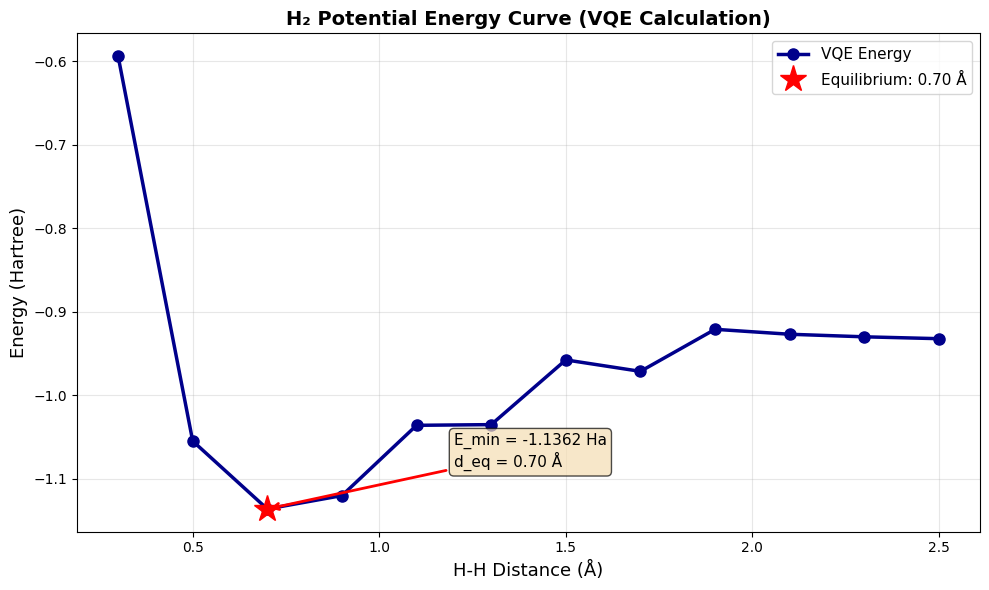


Equilibrium bond length: 0.70 Å
Ground state energy: -1.136187 Hartree
(Experimental: ~0.74 Å, ~-1.174 Ha for H2)


In [13]:
# Plot potential energy curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(distances, energies_h2, 'o-', linewidth=2.5, markersize=8, 
        color='darkblue', label='VQE Energy')

# Mark equilibrium distance
min_idx = np.argmin(energies_h2)
eq_distance = distances[min_idx]
eq_energy = energies_h2[min_idx]
ax.plot(eq_distance, eq_energy, 'r*', markersize=20, 
        label=f'Equilibrium: {eq_distance:.2f} Å')

ax.set_xlabel('H-H Distance (Å)', fontsize=13)
ax.set_ylabel('Energy (Hartree)', fontsize=13)
ax.set_title('H₂ Potential Energy Curve (VQE Calculation)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

# Add annotations
ax.annotate(f'E_min = {eq_energy:.4f} Ha\nd_eq = {eq_distance:.2f} Å',
            xy=(eq_distance, eq_energy), xytext=(eq_distance + 0.5, eq_energy + 0.05),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'h2_potential_curve.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: {RESULTS_DIR / 'h2_potential_curve.png'}")
plt.show()

print(f"\nEquilibrium bond length: {eq_distance:.2f} Å")
print(f"Ground state energy: {eq_energy:.6f} Hartree")
print("(Experimental: ~0.74 Å, ~-1.174 Ha for H2)")


## SECTION 7: QUANTUM NATURAL GRADIENT vs STANDARD GRADIENT

### Comparison: Standard Gradient Descent vs QNG

**Standard GD:** θ_{k+1} = θ_k - η ∇E  
**QNG:** θ_{k+1} = θ_k - η F^{-1} ∇E

The natural gradient accounts for the geometry of the parameter space,  
potentially leading to faster convergence, especially near stationary points.


In [23]:
print("\n--- Run comparison on Ising model ---\n")

# Standard gradient
vqe_standard = VQE_Ising_PSR_Adam(
    max_iter=200,
    learning_rate=0.05,
    store_history=True,
    reps=2,
    J=J,
    h=h
)

n_params = (vqe_standard.reps + 1) * 3
np.random.seed(42)
theta_init = np.random.uniform(0, 2*np.pi, n_params)

print("Standard Gradient (PSR + Adam):")
theta_std, E_std = vqe_standard.run(initial_params=theta_init.copy())
print(f"  Final Energy: {E_std:.6f}\n")

# Quantum Natural Gradient
vqe_qng = VQE_Ising_QNG(
    max_iter=200,
    learning_rate=0.1,
    decay=0.02,
    fisher_reg=1e-5,
    store_history=True,
    reps=2,
    J=J,
    h=h
)

print("Quantum Natural Gradient:")
theta_qng, E_qng = vqe_qng.run(initial_params=theta_init.copy())
print(f"  Final Energy: {E_qng:.6f}\n")


--- Run comparison on Ising model ---

Standard Gradient (PSR + Adam):
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Iteration 40/200 (20.0%)
Iteration 50/200 (25.0%)
Iteration 60/200 (30.0%)
Iteration 70/200 (35.0%)
Iteration 80/200 (40.0%)
Iteration 90/200 (45.0%)
Iteration 100/200 (50.0%)
Iteration 110/200 (55.0%)
Iteration 120/200 (60.0%)
Iteration 130/200 (65.0%)
Iteration 140/200 (70.0%)
Iteration 150/200 (75.0%)
Iteration 160/200 (80.0%)
Iteration 170/200 (85.0%)
Iteration 180/200 (90.0%)
Converged at iteration 187
  Final Energy: -2.499980

Quantum Natural Gradient:
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Iteration 40/200 (20.0%)
Iteration 50/200 (25.0%)
Iteration 60/200 (30.0%)
Iteration 70/200 (35.0%)
Iteration 80/200 (40.0%)
Iteration 90/200 (45.0%)
Iteration 100/200 (50.0%)
Iteration 110/200 (55.0%)


✓ Saved: results/12-1-Fynn/qng_vs_standard.png


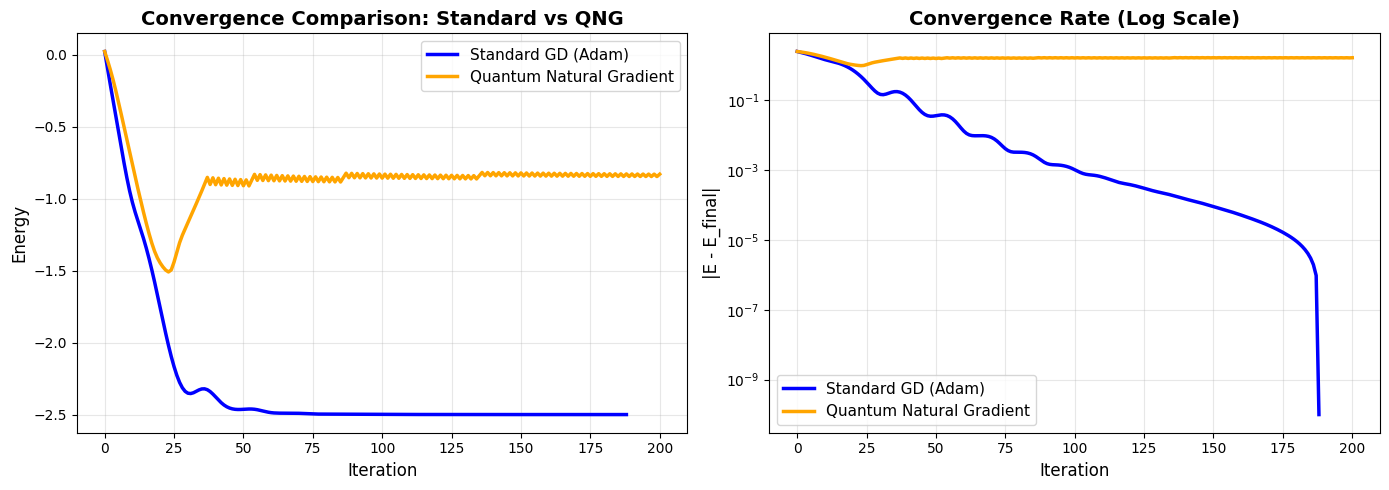

In [15]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Energy evolution
ax1 = axes[0]
ax1.plot(vqe_standard.history_energy, label='Standard GD (Adam)', 
         linewidth=2.5, color='blue')
ax1.plot(vqe_qng.history_energy, label='Quantum Natural Gradient', 
         linewidth=2.5, color='orange')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Energy', fontsize=12)
ax1.set_title('Convergence Comparison: Standard vs QNG', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Convergence rate (log scale)
ax2 = axes[1]
# Compute distance from final energy
baseline = min(E_std, E_qng)
error_std = np.abs(np.array(vqe_standard.history_energy) - baseline)
error_qng = np.abs(np.array(vqe_qng.history_energy) - baseline)

# Avoid log(0)
error_std = np.maximum(error_std, 1e-10)
error_qng = np.maximum(error_qng, 1e-10)

ax2.semilogy(error_std, label='Standard GD (Adam)', linewidth=2.5, color='blue')
ax2.semilogy(error_qng, label='Quantum Natural Gradient', linewidth=2.5, color='orange')
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('|E - E_final|', fontsize=12)
ax2.set_title('Convergence Rate (Log Scale)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'qng_vs_standard.png', dpi=300, bbox_inches='tight')
print(f" Saved: {RESULTS_DIR / 'qng_vs_standard.png'}")
plt.show()

## SECTION 8: ANSATZ DEPTH (EXPRESSIBILITY vs TRAINABILITY)

### Ansatz Depth Trade-off

**Shallow ansatz (low reps):**
- Fewer parameters → easier to optimize
- Less expressive → may not reach ground state

**Deep ansatz (high reps):**
- More parameters → harder to optimize
- More expressive → can represent complex states
- Risk of barren plateaus (vanishing gradients)

We test different ansatz depths on the Ising model.


In [22]:
reps_values = [0, 1, 2, 3, 4]
results_reps = []

print("\n--- Test ansatz depths ---")
for reps in reps_values:
    print(f"\nReps = {reps} (parameters: {(reps+1)*3})")
    
    vqe = VQE_Ising_PSR_Adam(
        max_iter=200,
        learning_rate=0.05,
        store_history=True,
        reps=reps,
        J=J,
        h=h
    )
    
    n_params = (reps + 1) * 3
    theta_init = np.random.uniform(0, 2*np.pi, n_params)
    
    theta_opt, E_opt = vqe.run(initial_params=theta_init)
    
    results_reps.append({
        'reps': reps,
        'n_params': n_params,
        'energy': E_opt,
        'history': vqe.history_energy
    })
    print(f"  Final Energy: {E_opt:.6f}")



--- Test ansatz depths ---

Reps = 0 (parameters: 3)
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Iteration 40/200 (20.0%)
Iteration 50/200 (25.0%)
Iteration 60/200 (30.0%)
Converged at iteration 68
  Final Energy: -2.491985

Reps = 1 (parameters: 6)
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Iteration 40/200 (20.0%)
Iteration 50/200 (25.0%)
Iteration 60/200 (30.0%)
Iteration 70/200 (35.0%)
Iteration 80/200 (40.0%)
Iteration 90/200 (45.0%)
Converged at iteration 90
  Final Energy: -2.499955

Reps = 2 (parameters: 9)
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Iteration 40/200 (20.0%)
Iteration 50/200 (25.0%)
Iteration 60/200 (30.0%)
Converged at iteration 69
  Final Energy: -2.099524

Reps = 3 (parameters: 12)
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Iteration 40/200 (20.0%


✓ Saved: results/12-1-Fynn/ansatz_depth_comparison.png


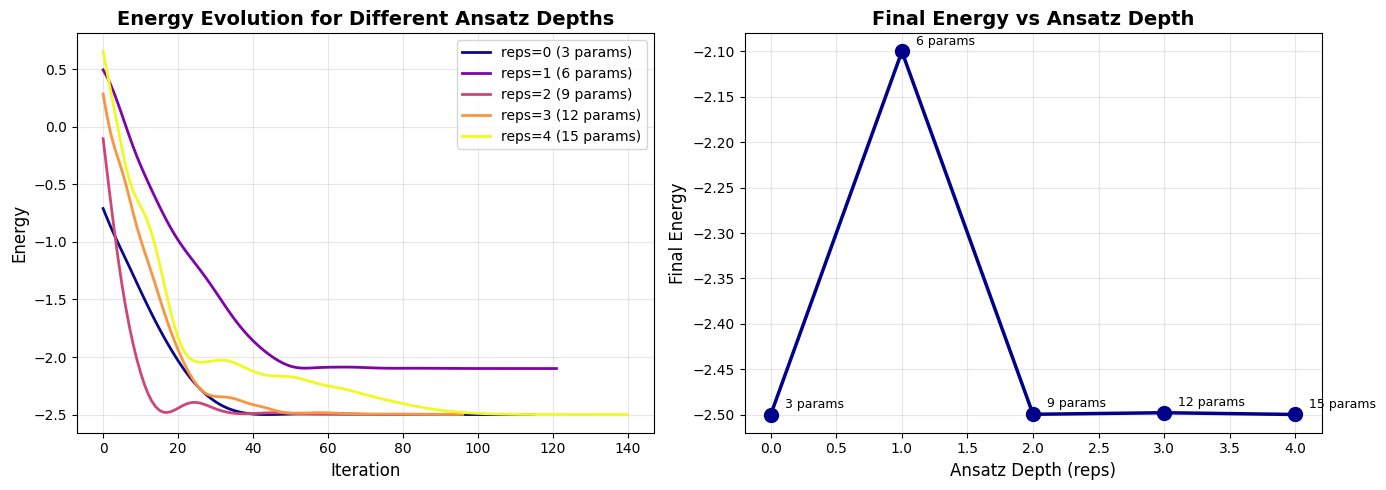

In [17]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Energy evolution
ax1 = axes[0]
colors_reps = plt.cm.plasma(np.linspace(0, 1, len(reps_values)))
for result, color in zip(results_reps, colors_reps):
    ax1.plot(result['history'], label=f"reps={result['reps']} ({result['n_params']} params)", 
             linewidth=2, color=color)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Energy', fontsize=12)
ax1.set_title('Energy Evolution for Different Ansatz Depths', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Final energy vs depth
ax2 = axes[1]
reps_list = [r['reps'] for r in results_reps]
energies_list = [r['energy'] for r in results_reps]
n_params_list = [r['n_params'] for r in results_reps]

ax2.plot(reps_list, energies_list, 'o-', linewidth=2.5, markersize=10, 
         color='darkblue')
ax2.set_xlabel('Ansatz Depth (reps)', fontsize=12)
ax2.set_ylabel('Final Energy', fontsize=12)
ax2.set_title('Final Energy vs Ansatz Depth', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add parameter count labels
for reps, energy, n_params in zip(reps_list, energies_list, n_params_list):
    ax2.annotate(f'{n_params} params', 
                xy=(reps, energy), xytext=(10, 5), 
                textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'ansatz_depth_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n Saved: {RESULTS_DIR / 'ansatz_depth_comparison.png'}")
plt.show()


## SECTION 9: GRADIENT COMPUTATION METHODS

### Comparison of Gradient Computation Methods

1. **Finite Differences:** O(n) evaluations, approximate
2. **Parameter Shift Rule:** 2n evaluations, exact
3. **SPSA:** 2 evaluations, stochastic

Testing on single qubit to see accuracy and efficiency.


In [18]:
methods_gradient = {
    'Finite Diff': VQE_OneQubit_FiniteDiff_Const(
        max_iter=100,
        learning_rate=0.05,
        gradient_eps=1e-6,
        store_history=True
    ),
    'Parameter Shift': VQE_OneQubit_PSR_Adam(
        max_iter=100,
        learning_rate=0.05,
        store_history=True,
        reps=0
    )
}

results_gradient = {}
theta_init = np.array([np.pi/2])

print("\n--- Testing gradient methods ---")
for name, optimizer in methods_gradient.items():
    print(f"\nMethod: {name}")
    theta_opt, E_opt = optimizer.run(initial_params=theta_init)
    results_gradient[name] = {
        'energy': E_opt,
        'error': abs(E_opt + np.sqrt(2)),
        'history': optimizer.history_energy
    }
    print(f"  Final Energy: {E_opt:.6f}")
    print(f"  Error: {abs(E_opt + np.sqrt(2)):.6e}")


--- Testing gradient methods ---

Method: Finite Diff
Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Iteration 20/100 (20.0%)
Iteration 30/100 (30.0%)
Iteration 40/100 (40.0%)
Iteration 50/100 (50.0%)
Iteration 60/100 (60.0%)
Iteration 70/100 (70.0%)
Converged at iteration 76
  Final Energy: -1.414207
  Error: 6.114589e-06

Method: Parameter Shift
Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Iteration 20/100 (20.0%)
Iteration 30/100 (30.0%)
Iteration 40/100 (40.0%)
Iteration 50/100 (50.0%)
Iteration 60/100 (60.0%)
Iteration 70/100 (70.0%)
Iteration 80/100 (80.0%)
Converged at iteration 87
  Final Energy: -1.414213
  Error: 3.608169e-07



 Saved: results/12-1-Fynn/gradient_methods.png


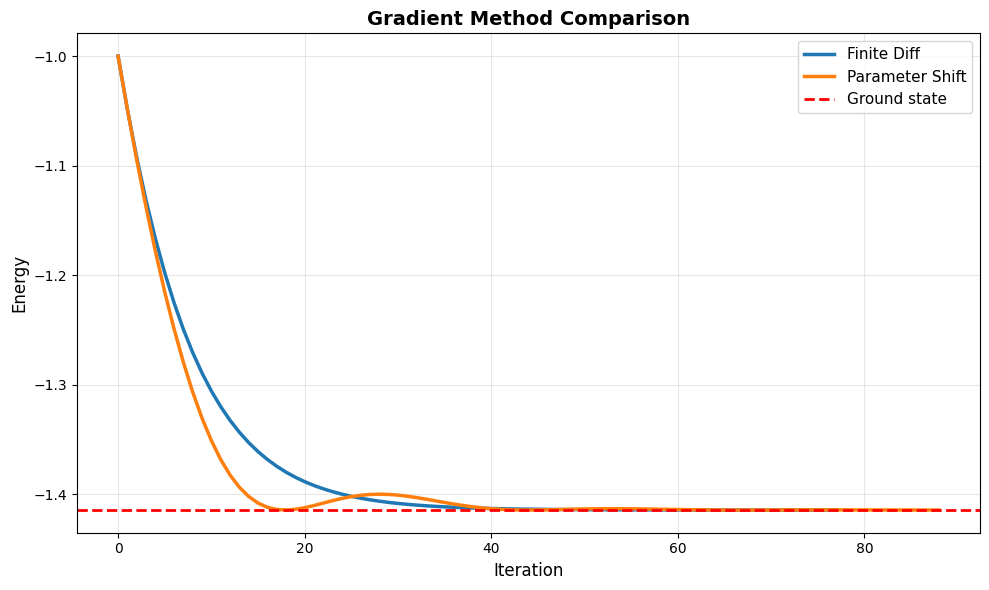

In [21]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for name, result in results_gradient.items():
    ax.plot(result['history'], label=name, linewidth=2.5)

ax.axhline(-np.sqrt(2), color='red', linestyle='--', linewidth=2, 
           label='Ground state')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Energy', fontsize=12)
ax.set_title('Gradient Method Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'gradient_methods.png', dpi=300, bbox_inches='tight')
print(f"\n Saved: {RESULTS_DIR / 'gradient_methods.png'}")
plt.show()